In [1]:
# ONLY DO THIS IN COLAB
from google.colab import auth
auth.authenticate_user()

# Set project ID, path to your credentials JSON
project_id = 'tnc-cameratraps'
credentials_file_path = 'capstone_service_account.json' # make sure you add the json file to colab file sys

# Set the environment
%env GOOGLE_APPLICATION_CREDENTIALS $credentials_file_path

env: GOOGLE_APPLICATION_CREDENTIALS=capstone_service_account.json


In [2]:
from google.cloud import storage
import pandas as pd
import numpy as np
import tensorflow as tf
import io
import json
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tqdm import tqdm
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# set gpu
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# init gcs
client = storage.Client()

# bucket name and important paths
bucket_name = 'lila_channel_islands_data'
data_path = 'lila_channel_islands_images_and_labels_all.csv'
images_folder = 'cropped_images/'

# download image file and label csv
df_blob = client.bucket(bucket_name).blob(data_path)
data = df_blob.download_as_text()
df = pd.read_csv(io.StringIO(data))
images_df = df['image_file'].values

# encode labels
num_classes = df['label'].nunique()
class_labels = df['label'].unique()
class_proportions = df['label'].value_counts(normalize=True).reset_index()
class_proportions.columns = ['labels', 'proportion']
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
labels_df = df['label'].values
labels_df = to_categorical(labels_df, num_classes)

In [6]:
print(class_labels)

['fox' 'skunk' 'rodent' 'bird' 'other' 'empty']


In [7]:
class_proportions.head()

,labels,proportion
0,fox,0.495285
1,rodent,0.430327
2,bird,0.062077
3,skunk,0.008775
4,empty,0.002679


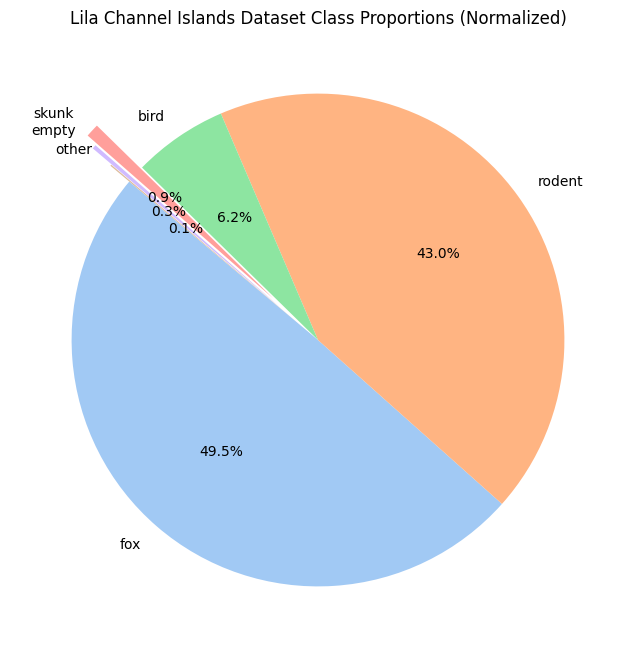

In [8]:
# Class distributions
plt.figure(figsize=(8, 8))
explode = [0, 0,0, .25 , .2, .1,]
sns.set_palette("pastel")
plt.pie(class_proportions['proportion'], labels=class_proportions['labels'], autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Lila Channel Islands Dataset Class Proportions (Normalized)')
plt.show()

In [9]:
# save label encoder
pickle_bytes_label_enc = pickle.dumps(label_encoder)
destination_blob_name = 'lila_channel_islands_efficentNet_label_encoder.pkl'
enc_blob = client.bucket(bucket_name).blob(destination_blob_name)
enc_blob.upload_from_string(pickle_bytes_label_enc, content_type='application/octet-stream')

In [10]:
# stratified train test split
from sklearn.model_selection import train_test_split

labels_integers = np.argmax(labels_df, axis=1)
train_val_indices, test_indices = train_test_split(range(len(labels_integers)), test_size=0.2, stratify=labels_integers, random_state=42)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.125, stratify=[labels_integers[i] for i in train_val_indices], random_state=42)


train_labels = labels_df[train_indices,:]
val_labels = labels_df[val_indices,:]
test_labels = labels_df[test_indices,:]

train_images = images_df[train_indices]
val_images = images_df[val_indices]
test_images = images_df[test_indices]

print(train_labels.shape, val_labels.shape, test_labels.shape)
print(len(train_images), len(val_images), len(test_images))


(58793, 6) (8400, 6) (16799, 6)
58793 8400 16799


In [31]:
#save train test split
import json

indices_data = {
    "train_indices": train_indices,
    "val_indices": val_indices,
    "test_indices": test_indices
}

indices_json = json.dumps(indices_data)
json_file_name = 'lila_channel_islands_train_val_test_split.json'
json_blob = client.bucket(bucket_name).blob(json_file_name)
json_blob.upload_from_string(indices_json, content_type='application/json')


In [11]:
#class distributions
train_proportions = pd.DataFrame(label_encoder.inverse_transform(np.argmax(train_labels, axis=1))).value_counts(normalize = True)
val_proportions = pd.DataFrame(label_encoder.inverse_transform(np.argmax(val_labels, axis=1))).value_counts(normalize = True)
test_proportions = pd.DataFrame(label_encoder.inverse_transform(np.argmax(test_labels, axis=1))).value_counts(normalize = True)
print("train proportions:\n ", train_proportions)
print("val proportions:\n ", val_proportions)
print("test proportions:\n ", test_proportions)

train proportions:
  fox       0.495297
rodent    0.430323
bird      0.062082
skunk     0.008760
empty     0.002670
other     0.000867
dtype: float64
val proportions:
  fox       0.495238
rodent    0.430357
bird      0.062024
skunk     0.008810
empty     0.002738
other     0.000833
dtype: float64
test proportions:
  fox       0.495268
rodent    0.430323
bird      0.062087
skunk     0.008810
empty     0.002679
other     0.000833
dtype: float64


In [12]:
#load and preprocess an image
def load_and_preprocess_image(image_path, label):
    image_blob = client.bucket(bucket_name).blob(
        images_folder + image_path.numpy().decode('utf-8'))
    if image_blob.exists():
        image_data = image_blob.download_as_bytes()
        image = tf.image.decode_image(image_data, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32)
        image.set_shape([224, 224, 3])
        label = tf.cast(label, tf.float32)
        label.set_shape([num_classes])
        return image, label
    else:
        return None

def _fixup_shape(images, labels):
    images.set_shape([224, 224, 3])
    labels.set_shape([num_classes])
    return images, labels

def create_data(images_arr, labels_arr):
  dataset = tf.data.Dataset.from_tensor_slices((images_arr, labels_arr))
  dataset = dataset.map(lambda x, y: tf.py_function(load_and_preprocess_image, [x, y], [tf.float32, tf.float32]),num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.filter(lambda x, y: x is not None)
  dataset = dataset.map(_fixup_shape)
  return dataset



In [13]:
# create tf datasets
train_dataset = create_data(train_images, train_labels)
val_dataset = create_data(val_images, val_labels)
test_dataset = create_data(test_images, test_labels)

In [14]:
# batch
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [19]:
# load pre-trained EfficientNetB0 model without top classification layers
base_model = EfficientNetB0(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# add fine-tuneing layers
x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

#unfreeze last 20 layers that are not batch norm
for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2[0][0]'

In [21]:
# training
epochs = 5
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/5
1838/1838 [==============================] - 2400s 1s/step - loss: 0.0745 - accuracy: 0.9833 - val_loss: 0.0458 - val_accuracy: 0.9908
Epoch 2/5
1838/1838 [==============================] - 2315s 1s/step - loss: 0.0431 - accuracy: 0.9910 - val_loss: 0.0426 - val_accuracy: 0.9918
Epoch 3/5
1838/1838 [==============================] - 2346s 1s/step - loss: 0.0335 - accuracy: 0.9926 - val_loss: 0.0453 - val_accuracy: 0.9911
Epoch 4/5
1838/1838 [==============================] - 2522s 1s/step - loss: 0.0262 - accuracy: 0.9939 - val_loss: 0.0442 - val_accuracy: 0.9908
Epoch 5/5
1838/1838 [==============================] - 2553s 1s/step - loss: 0.0210 - accuracy: 0.9946 - val_loss: 0.0466 - val_accuracy: 0.9910


In [23]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

1/1 [==============================] - 2s 2s/step
Average Test Accuracy: 99.00%


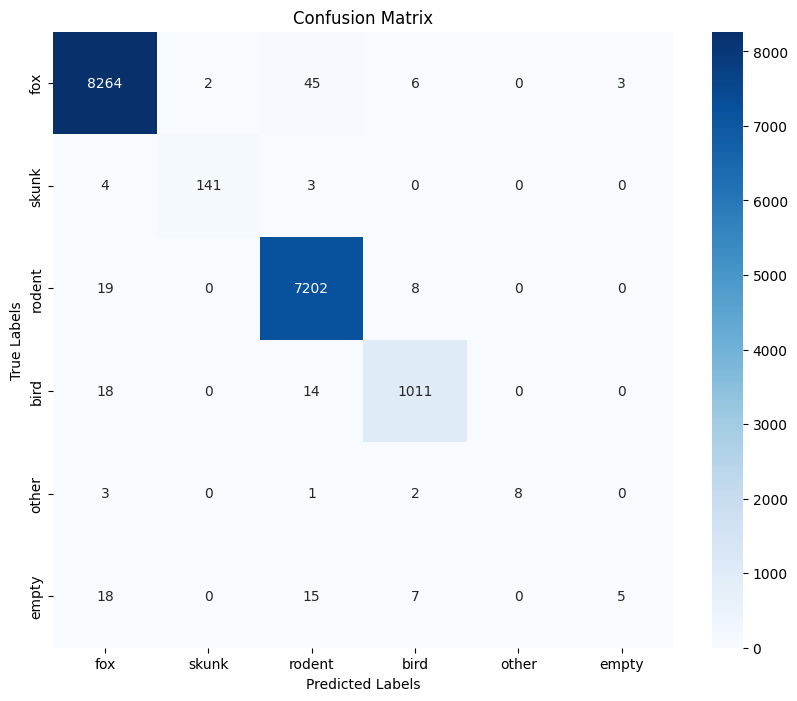

In [24]:
# Evaluate the model on the test dataset
test_accuracy = 0
num_batches = 0

conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for test_features, test_labels_enc in test_dataset:
    predicted_probs = model.predict(test_features)
    true_labels = label_encoder.inverse_transform(test_labels_enc.numpy().argmax(axis=1))
    predicted_labels = label_encoder.inverse_transform(predicted_probs.argmax(axis=1))

    # Calculate batch accuracy and update total accuracy
    batch_accuracy = accuracy_score(true_labels, predicted_labels)
    test_accuracy += batch_accuracy
    num_batches += 1

    # Update confusion matrix
    conf_matrix_batch = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    conf_matrix += conf_matrix_batch

# Calculate average accuracy over all batches
average_accuracy = test_accuracy / num_batches

# Print average accuracy
print("Average Test Accuracy: {:.2f}%".format(average_accuracy * 100))

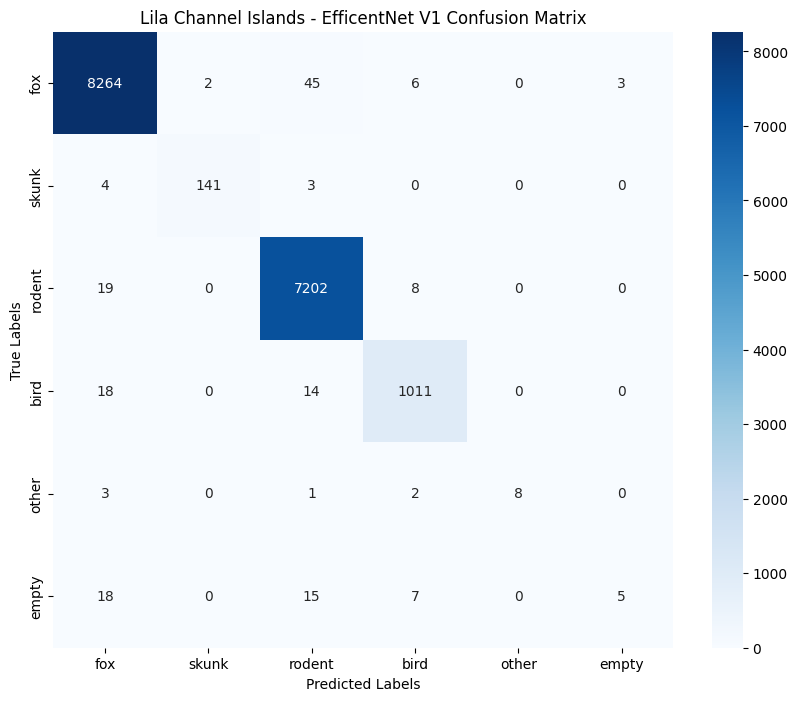

In [30]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Lila Channel Islands - EfficentNet V1 Confusion Matrix')
plt.show()

In [25]:
#class accuracies
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)


for i, label in enumerate(class_labels):
    print("Class {}: Accuracy: {:.2f}".format(label, class_accuracies[i]))

Class fox: Accuracy: 0.99
Class skunk: Accuracy: 0.95
Class rodent: Accuracy: 1.00
Class bird: Accuracy: 0.97
Class other: Accuracy: 0.57
Class empty: Accuracy: 0.11


In [26]:
# Upload model to gcp bucket
pickle_bytes = pickle.dumps(model)
destination_blob_name = 'lila_channel_islands_efficentNet_v1.pkl'
model_blob = client.bucket(bucket_name).blob(destination_blob_name)
model_blob.upload_from_string(pickle_bytes, content_type='application/octet-stream')